<a href="https://colab.research.google.com/github/BarGinger/ExplainableAIRadiology/blob/main/ex_1_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
# helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

if is_colab():
    # Enable the widgets extension for JupyterLab
    %pip install jupyterlab_widgets
    %pip install ipywidgets
    %pip install --upgrade torchsummary
    %pip install torch-summary
    %pip install onnx

Running in Google Colab


In [133]:
# Importing libraries
import pandas as pd
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

### Define Global objects

In [134]:
# Global helper functions
def get_class_names():
    return [
        'Pleural Effusion'
    ]

def get_policies():
    return [
        'ones',
        'zeroes',
        'mixed'
    ]

# Global variables

# Define the class names for the medical conditions
class_names = get_class_names()

# Define the policies for dataset preparation
policies = get_policies()

# Path to the zip file
zip_path = "./chexpert.zip"

# Path to the zip file in Google Drive
zip_file_in_drive = '/content/drive/MyDrive/chexpert.zip'  # Change this to your desired location

# Path to the directory where the datasets will be extracted
data_dir = "./CheXpert-v1.0-small"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the batch size
batch_size = 32

# Flag whether to modify the first layer of the model, meaning if we converted to gray scale and did not use tranformation to 3 channels
modify_first_layer = True

last_shape = 3
if modify_first_layer:
    last_shape = 1

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [135]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1+cu124
12.4
90300
True


# Dataset class

In [136]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CheXpertDataset(Dataset):
    def __init__(self, dataframe, class_names, zip_path, transform=None):
        # Initialize the dataset with a dataframe, class names, zip path, and optional transform
        self.dataframe = dataframe
        self.class_names = class_names
        self.transform = transform  # Use this later on to resize images and pre-process if needed

    def __len__(self):
        # Return the length of the dataframe, which is the number of samples in the dataset
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the image path from the dataframe at the given index
        img_path = self.dataframe.iloc[idx]['path']
        FOLDER = ""  # Define the folder path if needed
        img_path = FOLDER + img_path
        # Open the image and convert it to grayscale
        image = Image.open(img_path).convert("RGB") # convert to grayscale .convert('RGB')
        # Get the labels for the image from the dataframe and convert them to float32
        labels = self.dataframe.iloc[idx][self.class_names].values.astype('float32')
        # Convert the labels to a torch tensor
        labels = torch.tensor(labels, dtype=torch.float32)

        # Apply the transform to the image if provided
        if self.transform:
            image = self.transform(image)

        # Return the image and labels
        return image, labels

# Models classes

## Stacked model

In [137]:
import torch
import torch.nn as nn
import torchvision.models as models

class StackedModel(nn.Module):
    def __init__(self, n_labels, freeze_layers, modify_first_layer=False):
        super(StackedModel, self).__init__()
        self.base_model1 = models.mobilenet_v2(pretrained=True)
        self.base_model2 = models.densenet169(pretrained=True)

        if modify_first_layer:
            # Modify the first convolutional layer to accept 1-channel input for MobileNetV2
            self.base_model1.features[0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

            # Modify the first convolutional layer to accept 1-channel input for DenseNet169
            self.base_model2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        if freeze_layers:
            for param in self.base_model1.parameters():
                param.requires_grad = False
            for param in self.base_model2.parameters():
                param.requires_grad = False


        # # Ensure the modified first layers are not frozen
        # self.base_model1.features[0][0].weight.requires_grad = True
        # self.base_model2.features.conv0.weight.requires_grad = True

        self.base_model1.classifier = nn.Identity()
        self.base_model2.classifier = nn.Identity()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(1664 + 1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.base_model1.features(x)
        x1 = self.global_avg_pool(x1)
        x1 = torch.flatten(x1, 1)

        x2 = self.base_model2.features(x)
        x2 = self.global_avg_pool(x2)
        x2 = torch.flatten(x2, 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

def upload_stacked_models(n_labels=1, freeze_layers=True, modify_first_layer=False):
    """
    Create a stacked model using DenseNet169 and MobileNetV2 as base models.

    Parameters:
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The stacked model.
    """
    model = StackedModel(n_labels, freeze_layers, modify_first_layer=modify_first_layer)
    return model

# Preprocessing utils functions

In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
# import albumentations as albumentationsTranformation ## https://github.com/albumentations-team/albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2


# Global preprocessing functions

def prepare_dataset(dataframe, policy, class_names):
    """
    Prepare the dataset by filtering, shuffling, and filling missing values.

    Parameters:
    - dataframe: The input DataFrame containing the dataset.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.

    Returns:
    - x_path: Numpy array of image paths.
    - y: Numpy array of labels corresponding to the class names.
    """
    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = dataframe['Pleural Effusion'].value_counts()
    print(f"in dataframe Count for each class:\n{pleural_effusion_counts}")

    # Filter the dataset to include only frontal images
    dataset_df = dataframe[dataframe['Frontal/Lateral'] == 'Frontal']
    dataset_df = dataset_df.dropna(subset=['Pleural Effusion'])

    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = dataset_df['Pleural Effusion'].value_counts()
    print(f"in dataset_df (only Frontal) Count for each class:\n{pleural_effusion_counts}")

    # Extract image paths and labels
    x_path = dataset_df["Path"].to_numpy()
    y_df = dataset_df[class_names]

    # Count the occurrences of each unique value in the labels DataFrame
    pleural_effusion_counts = y_df.value_counts()
    print(f"in y_df Count for each class:\n{pleural_effusion_counts}")

    # Define classes to be treated as ones in the "mixed" policy
    class_ones = ['Atelectasis', 'Cardiomegaly']

    # Initialize the labels array
    y = np.empty(y_df.shape, dtype=int)

    # Define a dictionary to map policies to their corresponding actions
    policy_actions = {
        "ones": lambda cls: 1,
        "zeroes": lambda cls: 0,
        "mixed": lambda cls: 1 if cls in class_ones else 0
    }

    # Iterate over each row in the labels DataFrame
    for i, (index, row) in enumerate(y_df.iterrows()):
        labels = []
        for cls in class_names:
            curr_val = row[cls]
            if curr_val:
                curr_val = float(curr_val)
                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    feat_val = policy_actions.get(policy, lambda cls: 0)(cls)
                else:
                    feat_val = 0
            else:
                feat_val = 0
            labels.append(feat_val)
        y[i] = labels

    # Flatten the y array and convert to a pandas Series to get value counts
    y_flattened = y.flatten()
    y_series = pd.Series(y_flattened)
    pleural_effusion_counts = y_series.value_counts()
    print(f"in y (labels) Count for each class:\n{pleural_effusion_counts}")

    return x_path, y

def split_train_val(train_df, policy, class_names, test_size=0.2, random_state=42):
    """
    Split the training data into training and validation sets.

    Parameters:
    - train_df: DataFrame containing the training data.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.
    - test_size: Proportion of the training data to include in the validation set.
    - random_state: Random seed for reproducibility.

    Returns:
    - train_df: DataFrame containing the training data.
    - val_df: DataFrame containing the validation data.
    """
    # Prepare the training dataset
    train_paths, train_labels = prepare_dataset(train_df, policy, class_names)

    # Split the training dataset into training and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=test_size, random_state=random_state
    )

    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({'path': train_paths})
    train_labels_df = pd.DataFrame(train_labels, columns=class_names)
    train_df = pd.concat([train_df, train_labels_df], axis=1)

    val_df = pd.DataFrame({'path': val_paths})
    val_labels_df = pd.DataFrame(val_labels, columns=class_names)
    val_df = pd.concat([val_df, val_labels_df], axis=1)

    return train_df, val_df

def prepare_test_dataset(valid_df, policy, class_names):
    """
    Prepare the test dataset (original validation set).

    Parameters:
    - valid_df: DataFrame containing the original validation data.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.

    Returns:
    - test_df: DataFrame containing the test data.
    """
    # Prepare the test dataset
    test_paths, test_labels = prepare_dataset(valid_df, policy, class_names)

    # Create DataFrame for the test set
    test_df = pd.DataFrame({'path': test_paths})
    test_labels_df = pd.DataFrame(test_labels, columns=class_names)
    test_df = pd.concat([test_df, test_labels_df], axis=1)

    return test_df

def get_datasets(zip_path='chexpert.zip'):
    """
    Get the training, validation, and test datasets.

    Parameters:
    - zip_path: Path to the zip file containing the dataset.

    Returns:
    - train_df: DataFrame containing the training data.
    - validation_df: DataFrame containing the validation data.
    - test_df: DataFrame containing the test data.
    """
    # Read the training and validation data from the zip file
    original_train_df, test_df = read_zip(zip_path=zip_path)

    # Count the occurrences of each unique value in the "Pleural Effusion" column
    pleural_effusion_counts = original_train_df['Pleural Effusion'].value_counts()
    print(f"in original_train_df Count for each class:\n{pleural_effusion_counts}")

    policies = get_policies()
    class_names = get_class_names()

    # Select the policy to handle uncertain labels (-1)
    selected_policy = policies[0]

    # Split the original training data into separate training and validation sets
    train_df, validation_df = split_train_val(original_train_df, selected_policy, class_names)

    # Prepare the test dataset
    test_df = prepare_test_dataset(test_df, selected_policy, class_names)

    return train_df, validation_df, test_df

def read_zip(zip_path='chexpert.zip'):
    """
    Read training and validation data from a zip file.

    Parameters:
    - zip_path: Path to the zip file containing the dataset.

    Returns:
    - original_train_df: DataFrame containing the original training data.
    - test_df: DataFrame containing the original validation data.
    """
    original_train_df, test_df = None, None

    # Read CSV files from the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('train.csv') as train_file:
            original_train_df = pd.read_csv(train_file)
        with zip_ref.open('valid.csv') as valid_file:
            test_df = pd.read_csv(valid_file)

    return original_train_df, test_df

# Helper function to apply albumentations inside torchvision pipeline
class AlbumentationsWrapper:
    def __init__(self, albumentations_transform):
        self.albumentations_transform = albumentations_transform

    def __call__(self, img):
        img = np.array(img)  # Convert PIL image to numpy
        # Apply the transform with the named argument 'image'
        img = self.albumentations_transform(image=img)["image"]
        # Convert the image to a PyTorch tensor with resizable storage
        img = torch.from_numpy(np.array(img)).type(torch.FloatTensor)
        return img

def get_transform(augment=False):
    """
    Define the transformation pipeline for the images.

    Parameters:
    - augment: Whether to apply data augmentation.

    Returns:
    - transform: Composed transformation pipeline.
    """

    transform_list = [
        A.Resize(224, 224),  # Resize images to 224x224 pixels
        A.ToGray(p=1.0, num_output_channels=1, method="pca"),  # Convert to grayscale
        A.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize grayscale images
    ]

    if augment:
        transform_list.extend([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ElasticTransform(alpha=1, sigma=50, p=0.5),  # Removed alpha_affine
            A.GaussianBlur(p=0.2),
            A.Rotate(limit=10, p=0.5),
            # Using Affine instead of ShiftScaleRotate
            A.Affine(
                scale=(0.9, 1.1),  # Scale factor range
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translation range
                rotate=(-10, 10),  # Rotation range in degrees
                p=0.5  # Probability of applying the transform
            ),
            # Replaced CropAndPad with Crop
            A.Crop(x_min=0, y_min=0, x_max=224, y_max=224, p=0.5),
            A.RandomCrop(height=224, width=224, p=0.5) #This will randomly crop the image, hopefully focusing on different areas
        ])

    transform_list.append(ToTensorV2())

    #Wrap the list in albumentation wrapper
    albumentations_transform = A.Compose(transform_list, p=1.0, bbox_params=None, keypoint_params=None, additional_targets=None)

    #return a wrapper to apply the transformation with additional_target
    return AlbumentationsWrapper(albumentations_transform)

def transform_dataset(df, zip_path='chexpert.zip', batch_size=16, shuffle=True, augment=False, sampler=False, num_workers=2):
    """
    Transform the dataset into DataLoader objects for given dataframe.

    Parameters:
    - df: DataFrame containing the dataset.
    - zip_path: Path to the zip file containing the images.
    - batch_size: Number of samples in each batch.
    - shuffle: Whether to shuffle the data.
    - augment: Whether to apply data augmentation.
    - sampler (bool): Whether to use a sampler for the DataLoader.
    - num_workers: Number of worker processes for data loading.

    Returns:
    - dataset: CheXpertDataset object containing the dataset.
    - loader: DataLoader object containing the dataset.
    - images: Batch of images from the DataLoader.
    - labels: Batch of labels from the DataLoader.
    """
    # Define the class names for the medical conditions
    class_names = get_class_names()

    # Get the transformation pipeline
    transformer = get_transform(augment=augment)

    # Create the dataset with the defined transformations
    dataset = CheXpertDataset(dataframe=df, class_names=class_names, zip_path=zip_path, transform=transformer)

    if sampler:
        # Calculate class weights
        class_counts = df['Pleural Effusion'].value_counts()
        class_weights = 1. / class_counts
        sample_weights = df['Pleural Effusion'].map(class_weights)
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        # Use the sampler in the DataLoader
        loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)
    else:
        # Create DataLoader for the dataset
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)

    # Verify data loading by fetching a batch of images and labels from the DataLoader
    images, labels = next(iter(loader))

    return dataset, loader, images, labels

# Train model functions

In [139]:
import os

# Check if the folder exists
if not os.path.exists('finetuned_models'):
  # Create the folder if it doesn't exist
  os.makedirs('finetuned_models')
  print("Folder 'finetuned_models' created successfully.")
else:
  print("Folder 'finetuned_models' already exists.")


Folder 'finetuned_models' already exists.


In [140]:
## Helper functions for training PyTorch models.

import os
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.amp as amp  # Import the new amp module
# import torchxrayvision as xrv

def train_model(model, train_loader: DataLoader, test_loader: DataLoader, criterion, optimizer, scheduler, num_epochs=5, model_name='model', device='cuda', patience=5, num_workers=2):
    """
    Train a PyTorch model with the given parameters.

    Parameters:
    - model: The PyTorch model to be trained.
    - train_loader: DataLoader for the training dataset.
    - test_loader: DataLoader for the validation dataset.
    - criterion: The loss function.
    - optimizer: The optimizer.
    - scheduler: The learning rate scheduler.
    - num_epochs: Number of epochs to train the model.
    - model_name: Name to save the trained model.
    - device: Device to train the model on ('cpu' or 'cuda').
    - patience: Number of epochs to wait for improvement before stopping early.
    - num_workers: Number of worker processes for data loading.

    Returns:
    - train_losses: List of training losses for each epoch.
    - train_accuracies: List of training accuracies for each epoch.
    - test_losses: List of validation losses for each epoch.
    - test_accuracies: List of validation accuracies for each epoch.
    - test_aucs: List of validation AUCs for each epoch.
    """
    model.to(device)

    scaler = amp.GradScaler(device=device)  # Initialize the GradScaler for mixed precision training
    save_path = f"finetuned_models/{model_name}.pkl"

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    test_aucs = []

    best_loss = float('inf')
    epochs_no_improve = 0

    print(f"Training {model_name} model for {num_epochs} epochs")
    for epoch in range(num_epochs):
        model.train()
        total_train = 0
        correct_train = 0
        train_loss = 0.0

        # Add a progress bar for the training loop
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                # Flatten the labels if needed
                # labels = labels.squeeze(1)

                optimizer.zero_grad()
                with amp.autocast(device_type="cuda", dtype=torch.float16): # Use autocast for mixed precision training
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()  # Scale the loss for mixed precision training
                scaler.step(optimizer)
                scaler.update()

                # Accuracy and loss calculation
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                # Calculate accuracy per sample (averaged over labels)
                correct_train += (predicted == labels).sum().item() / labels.size(1)
                total_train += labels.size(0)
                train_loss += loss.item()

                pbar.update(1)

        # Store the average metrics for this epoch
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation phase (Test set)
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0
        all_labels = []
        all_outputs = []

        with tqdm(total=len(test_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Evaluation", unit="batch") as pbar:
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item() / labels.size(1)
                    test_loss += criterion(outputs, labels).item()

                    all_labels.append(labels.cpu().numpy())
                    all_outputs.append(outputs.cpu().numpy())

                    pbar.update(1)

        test_accuracy = correct_test / total_test
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # Calculate AUC
        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)
        test_auc = roc_auc_score(all_labels, all_outputs)
        test_aucs.append(test_auc)

        # Print the results for this epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, Test AUC: {test_aucs[-1]:.4f}")

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_outputs)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Epoch {epoch + 1}')
        plt.legend(loc="lower right")
        plt.show()

        # Early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model for epoch {epoch + 1} for model {model_name}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1} for model {model_name}")
                break

        # Adjust the learning rate based on the validation loss
        scheduler.step(test_loss)

    save_model(model, model_name=model_name, device=device)

    return train_losses, train_accuracies, test_losses, test_accuracies, test_aucs

def upload_pretrained_densenet169(pretrained_model, add_layers=True, n_labels=1, freeze_layers=True, unfreeze_modules=['features.denseblock4'],
                                  modify_first_layer=False):
    """
    Modify a pre-trained DenseNet169 model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - pretrained_model: The pre-trained model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (clupload_pretrained_densenet169asses).
    - freeze_layers: Boolean indicating whether to freeze the original layers.
    - unfreeze_modules: List of layer names or indices to unfreeze (e.g., 'features.denseblock4').

    Returns:
    - The modified model.
    """
    # Step 1: Freeze all layers
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = False

    # Step 2: Unfreeze specific layers (if specified)
    if unfreeze_modules:
        for name, child in pretrained_model.named_modules():
            if any(layer_name in name for layer_name in unfreeze_modules):
                for param in child.parameters():
                    param.requires_grad = True

    # Step 3: Modify the first convolutional layer to accept 1-channel input for DenseNet169
    if modify_first_layer:
        pretrained_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Step 4: Add custom layers if specified
    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_labels)
        )

    return pretrained_model

def upload_pretrained_densenet201(add_layers=True, n_labels=1, freeze_layers=True, unfreeze_modules=['features.denseblock4'],
                                  modify_first_layer=False):
    """
    Modify a pre-trained DenseNet201 model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - pretrained_model: The pre-trained model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.
    - unfreeze_modules: List of layer names or indices to unfreeze (e.g., 'features.denseblock4').
    - modify_first_layer: Boolean indicating whether to modify the first conv layer for single-channel input.

    Returns:
    - The modified model.
    """
    # Load the pre-trained DenseNet201 model with ImageNet weights
    pretrained_model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)

    # Step 1: Freeze all layers
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = True # change it to train everything

    # Step 2: Unfreeze specific layers (if specified)
    if unfreeze_modules:
        for name, child in pretrained_model.named_modules():
            if any(layer_name in name for layer_name in unfreeze_modules):
                for param in child.parameters():
                    param.requires_grad = True

    # Step 3: Modify the first convolutional layer to accept 1-channel input for DenseNet201
    if modify_first_layer:
        pretrained_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Step 4: Add custom layers if specified
    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_labels)
        )

    return pretrained_model


def upload_pretrained_vit(vit_model, add_layers=True, n_labels=5, freeze_layers=True):
    """
    Modify a pre-trained Vision Transformer (ViT) model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - vit_model: The pre-trained ViT model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The modified ViT model.
    """
    if freeze_layers:
        for param in vit_model.parameters():
            param.requires_grad = False

    if add_layers:
        # Access the first module inside the Sequential container to get in_features
        if isinstance(vit_model.heads, nn.Sequential):
            in_features = vit_model.heads[0].in_features
        else:
            in_features = vit_model.heads.in_features

        vit_model.heads = nn.Sequential(
            nn.Linear(in_features, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, n_labels)
        )

    return vit_model

def upload_pretrained_densenet121(pretrained_model, add_layers=True, n_labels=1, freeze_layers=True):
    """
    Modify a pre-trained DenseNet121 model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - pretrained_model: The pre-trained model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The modified model.
    """
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = False

    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, n_labels)
        )

    return pretrained_model

def upload_stacked_models(n_labels=1, freeze_layers=True):
    """
    Create a stacked model using DenseNet169 and MobileNetV2 as base models.

    Parameters:
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The stacked model.
    """
    class StackedModel(nn.Module):
        def __init__(self, n_labels, freeze_layers):
            super(StackedModel, self).__init__()
            self.base_model1 = models.densenet169(pretrained=True)
            self.base_model2 = models.mobilenet_v2(pretrained=True)

            if freeze_layers:
                for param in self.base_model1.parameters():
                    param.requires_grad = False
                for param in self.base_model2.parameters():
                    param.requires_grad = False

            self.base_model1.classifier = nn.Identity()
            self.base_model2.classifier = nn.Identity()

            self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Sequential(
                nn.Linear(1664 + 1280, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(128, n_labels),
                nn.Sigmoid()
            )

        def forward(self, x):
            x1 = self.base_model1.features(x)
            x1 = self.global_avg_pool(x1)
            x1 = torch.flatten(x1, 1)

            x2 = self.base_model2.features(x)
            x2 = self.global_avg_pool(x2)
            x2 = torch.flatten(x2, 1)

            x = torch.cat((x1, x2), dim=1)
            x = self.fc(x)
            return x

    model = StackedModel(n_labels, freeze_layers)
    return model

def save_model(model, model_name, device='cuda'):
    """
    Save a PyTorch model to a file using pickle and ONNX.

    Parameters:
    - model: The PyTorch model to be saved.
    - model_name: The name of the model to save.
    - device: Device to save the model on ('cpu' or 'cuda').
    """
    pickle_path = f"finetuned_models/{model_name}.pkl"
    print(f"Model pickled saved in {pickle_path}")
    torch.save(model, pickle_path)

    pth_path = f"finetuned_models/{model_name}.pth"
    print(f"Model pth saved in {pth_path}")
    torch.save(model.state_dict(), pth_path)

    # Define dummy input for ONNX export (batch size 1, 1 channel, 224x224 image size)
    dummy_input = torch.randn(1, last_shape, 224, 224).to(device)

    # Export the model to ONNX format
    onnx_path = f"finetuned_models/{model_name}.onnx"
    torch.onnx.export(model, dummy_input, onnx_path,
                      input_names=["input"],
                      output_names=["output"],
                      opset_version=11)

    print(f"Model saved as onnx in {onnx_path}")

def load_model(filename, device='cuda'):
    """
    Load a PyTorch model from a file.

    Parameters:
    - filename: The name of the file to load the model from.
    - device: Device to load the model on ('cpu' or 'cuda').

    Returns:
    - The loaded PyTorch model.
    """
    path = f"finetuned_models/{filename}"
    loaded_model = torch.load(path, map_location=device)
    return loaded_model

def predict_model(model, loader, device='cuda'):
    """
    Predict using a trained PyTorch model.

    Parameters:
    - model: The trained PyTorch model.
    - loader: DataLoader for the dataset to predict on.
    - device: Device to run the predictions on ('cpu' or 'cuda').

    Returns:
    - predictions: Numpy array of predictions.
    - labels: Numpy array of true labels.
    """
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_roc_curve(labels, preds, model_name):
    """
    Plot the ROC curve for the given model.

    Parameters:
    - labels: Numpy array of true labels.
    - preds: Numpy array of predicted probabilities.
    - model_name: Name of the model.

    Returns:
    - None
    """
    class_names = get_class_names()
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for model {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

### Download dataset from Kaggle or Google Drive

In [141]:
if is_colab():
  from google.colab import drive
  # Mount Google Drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
import os
import shutil
import subprocess

# Check if Google Drive is mounted and the zip file exists
drive_mounted = os.path.exists('/content/drive')
zip_in_drive = os.path.exists(zip_file_in_drive)

# Check if the dataset is already downloaded locally, if not download it
print(f"Checking if dataset zip file exists at {zip_path}")
if not os.path.exists(zip_path):
    # Use the zip file from Google Drive if available, otherwise download
    print("Dataset zip file not found locally, searching in drive if connected.")
    if drive_mounted and zip_in_drive:
        print("Using dataset from Google Drive.")
        zip_path = zip_file_in_drive  # Update zip_path to use the Drive location
    else:
        print("Downloading the dataset...")
        # Check if kaggle is installed
        try:
            subprocess.run(["kaggle", "--version"], check=True)
            print("Kaggle is already installed.")
        except subprocess.CalledProcessError:
            print("Kaggle is not installed. Installing kaggle...")
            %pip install kaggle

        # Check if the kaggle.json file exists in the destination
        kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
        if not os.path.exists('kaggle.json') and not os.path.exists(kaggle_json_path):
            # Move kaggle.json to ~/.kaggle
            os.makedirs(os.path.dirname(kaggle_json_path), exist_ok=True)
            shutil.move('kaggle.json', kaggle_json_path)
            # Set permissions
            os.chmod(kaggle_json_path, 0o600)
        else:
            print("kaggle.json already exists in the destination.")

        # Download the dataset from Kaggle
        subprocess.run(["kaggle", "datasets", "download", "-d", "ashery/chexpert"], check=True)
        print("Dataset was downloaded from Kaggle.")

        if drive_mounted:
            print("Saving dataset to Google Drive for future use.")
            shutil.copy(zip_path, zip_file_in_drive)
            print(f"Dataset saved to {zip_file_in_drive}")

else:
    print("Dataset already downloaded.")

Checking if dataset zip file exists at ./chexpert.zip
Dataset zip file not found locally, searching in drive if connected.
Using dataset from Google Drive.


### Extract the zip file to improve performance

In [143]:
import zipfile

# Check if the dataset is already extracted, if not extract it
if not os.path.exists(data_dir):
    print("Extracting the dataset...")
    #unzip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    #list files in the extracted dir
    os.listdir(data_dir)
else:
    print("Dataset already extracted.")

Dataset already extracted.


## Save zip to google drive if you want to save time next time running this notebook

### Load train, validtion and test datasets

In [144]:
# Load the datasets
train_df, validation_df, test_df = get_datasets(zip_path)

if train_df is None or validation_df is None or test_df is None:
    print("Error loading the datasets.")
else:
    print("Datasets loaded successfully.")

in original_train_df Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
in dataframe Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
in dataset_df (only Frontal) Count for each class:
Pleural Effusion
 1.0    76899
 0.0    25299
-1.0     9578
Name: count, dtype: int64
in y_df Count for each class:
Pleural Effusion
 1.0                76899
 0.0                25299
-1.0                 9578
Name: count, dtype: int64
in y (labels) Count for each class:
1    86477
0    25299
Name: count, dtype: int64
in dataframe Count for each class:
Pleural Effusion
0.0    167
1.0     67
Name: count, dtype: int64
in dataset_df (only Frontal) Count for each class:
Pleural Effusion
0.0    138
1.0     64
Name: count, dtype: int64
in y_df Count for each class:
Pleural Effusion
0.0                 138
1.0                  64
Name: count, dtype: int64
in y (labels) Count for each class:
0    138

#### Peak into training dataset

In [145]:
# Print some information about the train DataFrame
display(train_df.head())
print("Number of rows and columns in the train DataFrame:", train_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(train_df.dtypes)

# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = train_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient16646/study1/...,1
1,CheXpert-v1.0-small/train/patient10056/study9/...,1
2,CheXpert-v1.0-small/train/patient42372/study4/...,1
3,CheXpert-v1.0-small/train/patient45046/study5/...,1
4,CheXpert-v1.0-small/train/patient05198/study2/...,0


Number of rows and columns in the train DataFrame: (89420, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object
Count for each class:
Pleural Effusion
1    69302
0    20118
Name: count, dtype: int64


### Peak into the validation dataset

In [146]:
# Print some information about the validtion DataFrame
# Set pandas display options to show all columns
display(validation_df.head())
print("Number of rows and columns in the validation DataFrame:", validation_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(validation_df.dtypes)

# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = validation_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient48924/study2/...,1
1,CheXpert-v1.0-small/train/patient38687/study1/...,1
2,CheXpert-v1.0-small/train/patient03187/study2/...,1
3,CheXpert-v1.0-small/train/patient37033/study15...,1
4,CheXpert-v1.0-small/train/patient25492/study1/...,0


Number of rows and columns in the validation DataFrame: (22356, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object
Count for each class:
Pleural Effusion
1    17175
0     5181
Name: count, dtype: int64


#### Peak into the test dataset

In [147]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
display(test_df.head())
print("Number of rows and columns in the test DataFrame:", test_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(test_df.dtypes)


# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = test_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0
2,CheXpert-v1.0-small/valid/patient64543/study1/...,0
3,CheXpert-v1.0-small/valid/patient64544/study1/...,0
4,CheXpert-v1.0-small/valid/patient64545/study1/...,1


Number of rows and columns in the test DataFrame: (202, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object
Count for each class:
Pleural Effusion
0    138
1     64
Name: count, dtype: int64


#### Dataset formation according to torch (using dataloaders)

In [150]:
num_of_workers = 0
if is_colab():
    num_of_workers = 4

# Transform the training dataset
train_dataset, train_loader, train_images, train_labels = transform_dataset(train_df, zip_path, batch_size=batch_size, shuffle=True, augment=True, sampler=True, num_workers=num_of_workers)

# Transform the validation dataset
validtion_dataset, validation_loader, validtion_images, validtion_labels = transform_dataset(validation_df, zip_path, batch_size=batch_size, shuffle=False, augment=False, num_workers=num_of_workers)

# Transform the test dataset
test_dataset, test_loader, test_images, test_labels = transform_dataset(test_df, zip_path, batch_size=batch_size, shuffle=False, augment=False, num_workers=num_of_workers)

#### Visualising example

Image 20, Label: 0.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


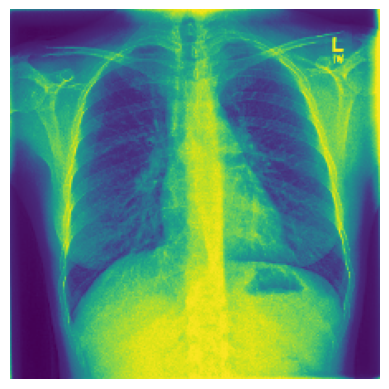

Image 21, Label: 0.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


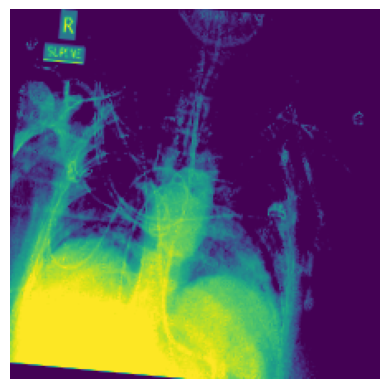

Image 22, Label: 1.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


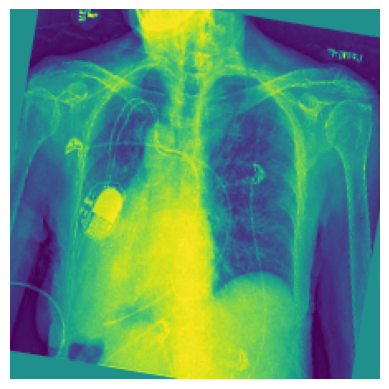

Image 23, Label: 1.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


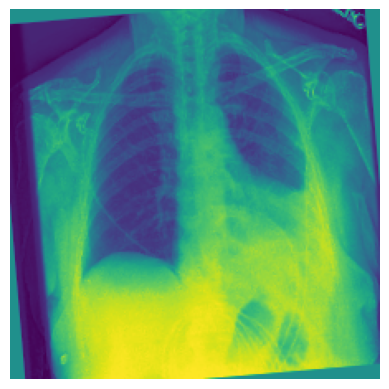

Image 24, Label: 1.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


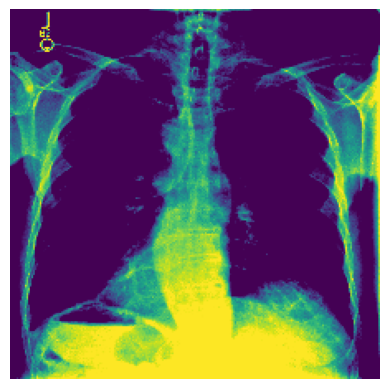

Image 25, Label: 0.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


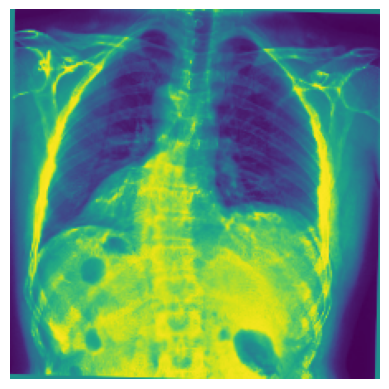

Image 26, Label: 0.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


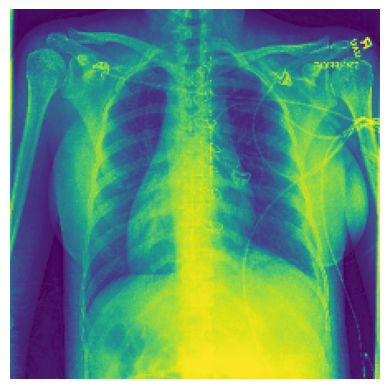

Image 27, Label: 0.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


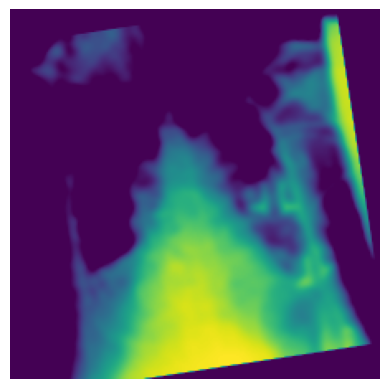

Image 28, Label: 1.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


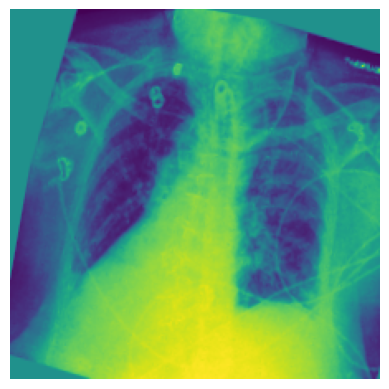

Image 29, Label: 0.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


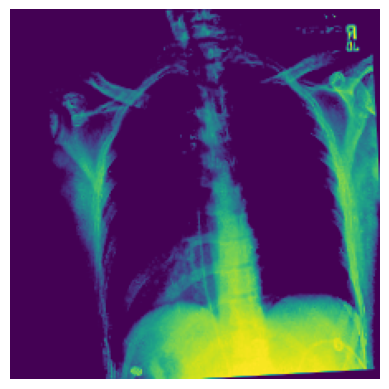

Image 30, Label: 1.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


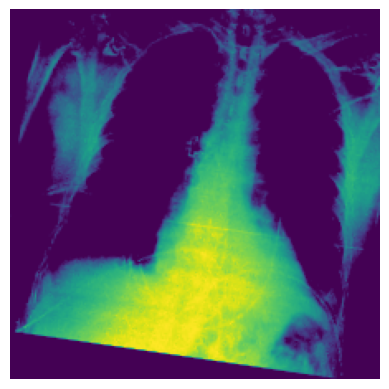

In [153]:
# Select the first image in the batch
for i in range(20, 31):
    image = train_images[i]
    label = train_labels[i]
    print(f"Image {i}, Label: {label.item()}")
    original_shape = image.shape
    image = image.permute(1, 2, 0).numpy()  # Change shape to (224, 224)
    new_shape = image.shape
    print(f"Original shape: {original_shape}, New shape: {new_shape}")
    # Check the shape of the image to ensure it is (224, 224, last_shape)
    assert new_shape == (224, 224, last_shape), f"Expected shape (224, 224), but got {image.shape}"

    # Denormalize the image for visualization
    image = (image * 0.5) + 0.5

    # Plot the image
    print("Example image:")
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Choose model to train, execute only the one you wish to train

In [157]:
# Load a pre-trained DenseNet169 model, add custom layers, and freeze certain layers
#
# Parameters:
# - pretrained: Use a pre-trained version of DenseNet169
# - add_layers: Add custom layers to the model
# - n_labels: Number of output labels (classes)
# - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training

# Load the pre-trained DenseNet169 model with ImageNet weights
denseNet169 = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)

# Modify the DenseNet169 model by adding custom layers and freezing certain layers
model = upload_pretrained_densenet169(denseNet169, add_layers=True, n_labels=len(class_names), freeze_layers=False, modify_first_layer=modify_first_layer)

# Move the model to the appropriate device (e.g., 'cuda' for GPU or 'cpu' for CPU)
model.to(device)

# Define the model name for saving purposes
model_name = "densenet169"

#### Here we can extract different pre-trained models

### Train DenseNet201

In [44]:
# Modify the DenseNet201 model by adding custom layers and freezing certain layers
model = upload_pretrained_densenet201(add_layers=True, n_labels=len(class_names), freeze_layers=True, modify_first_layer=modify_first_layer)

# Move the model to the appropriate device (e.g., 'cuda' for GPU or 'cpu' for CPU)
model.to(device)

# Define the model name for saving purposes
model_name = "densenet201"

#### Summary of Model

In [158]:
# Display the model summary, input size (last_shape (1 or 3) channel/s, 224x224 image)
summary(model, input_size=(last_shape, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             45,440
|    |    └─_DenseLayer: 3-2             49,600
|    |    └─_DenseLayer: 3-3             53,760
|    |    └─_DenseLayer: 3-4             57,920
|    |    └─_DenseLayer: 3-5             62,080
|    |    └─_DenseLayer: 3-6             66,240
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             512
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  32,768
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            53,760
|    |    └─_DenseLayer: 3-12            57,920
|    |    └─_DenseLayer: 3-13 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             45,440
|    |    └─_DenseLayer: 3-2             49,600
|    |    └─_DenseLayer: 3-3             53,760
|    |    └─_DenseLayer: 3-4             57,920
|    |    └─_DenseLayer: 3-5             62,080
|    |    └─_DenseLayer: 3-6             66,240
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             512
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  32,768
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            53,760
|    |    └─_DenseLayer: 3-12            57,920
|    |    └─_DenseLayer: 3-13 

#### Here is how we train the model

Training densenet169 model for 20 epochs


Epoch 1/20 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 1/20 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [1/20], Train Loss: 0.3786, Train Accuracy: 0.8482, Test Loss: 0.3276, Test Accuracy: 0.8600, Test AUC: 0.9365


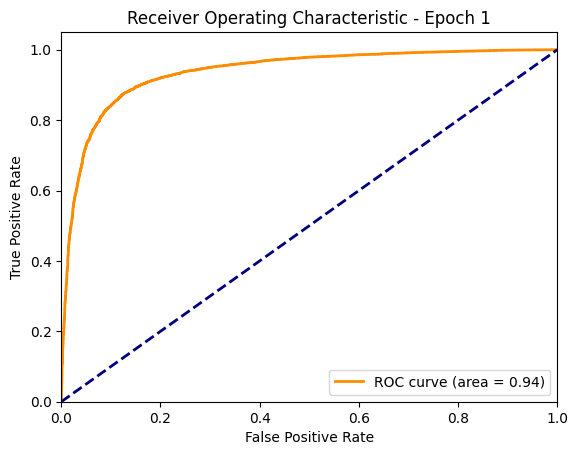

Saved new best model for epoch 1 for model densenet169


Epoch 2/20 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Calculate class weights to handle class imbalance
# The weight for the positive class (Pleural Effusion = 1) is calculated as:
# total number of samples / (2 * number of positive samples)
# This ensures that the positive class is given more importance during training.
class_weights = torch.tensor([1.0, len(train_df['Pleural Effusion']) / (2 * sum(train_df['Pleural Effusion']))], dtype=torch.float32)


pos_weight = torch.tensor([class_weights[1]], dtype=torch.float32).to(device)


# Define the loss function with class weights
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss() # pos_weight=pos_weight


# Define the loss function, optimizer, and scheduler
# criterion = nn.BCEWithLogitsLoss()
# optimizer_densenet = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.StepLR(optimizer_densenet, step_size=7, gamma=0.1)


# Define the optimizer with weight decay
# AdamW optimizer with a learning rate of 0.001 and weight decay of 1e-5
optimizer_densenet = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Define a learning rate scheduler
# ReduceLROnPlateau reduces the learning rate when a metric has stopped improving
scheduler = ReduceLROnPlateau(optimizer_densenet, mode='min', factor=0.1, patience=5)

# Define the number of epochs
num_epochs = 20

# Train the model
# Parameters:
# - model: The model to be trained (DenseNet169 in this case)
# - train_loader: DataLoader for the training dataset
# - test_loader: DataLoader for the validation dataset
# - criterion: The loss function
# - optimizer: The optimizer
# - scheduler: The learning rate scheduler
# - num_epochs: Number of epochs to train the model
# - device: Device to train the model on ('cpu' or 'cuda')
# - model_name: Filename to save the trained model
# - num_workers: Number of worker processes for data loading
train_losses, train_accuracies, test_losses, test_accuracies, test_aucs = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=validation_loader,
    criterion=criterion,
    optimizer=optimizer_densenet,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    model_name=model_name,
    num_workers=2
)

# Adjust the learning rate based on the validation loss
for epoch in range(num_epochs):
    # ... (training and evaluation code) ...
    scheduler.step(test_losses[-1])  # Adjust the learning rate based on the latest validation loss
    # Get and print the last learning rate
    last_lr = scheduler.get_last_lr()[0]  # Access the learning rate
    print(f"Epoch {epoch + 1}, Last Learning Rate: {last_lr}")

In [ ]:
pickle_path = f"finetuned_models/{model_name}.pkl"
print(f"Model pickled saved in {pickle_path}")
# Save the model using pickle
torch.save(model, pickle_path)

pth_path = f"finetuned_models/{model_name}.pth"
print(f"Model pth saved in {pth_path}")
torch.save(model.state_dict(), pth_path)

# Define dummy input for ONNX export (batch size 1, 3 channels, 224x224 image size)
dummy_input = torch.randn(1, last_shape, 224, 224).to(device)  # Move dummy input to GPU

# Export the model to ONNX format
onnx_path = f"finetuned_models/{model_name}.onnx"
torch.onnx.export(model, dummy_input, onnx_path,
                input_names=["input"],
                output_names=["output"],
                opset_version=11)

print(f"Model saved as onnx in {onnx_path}")

### Evaluate the trained model

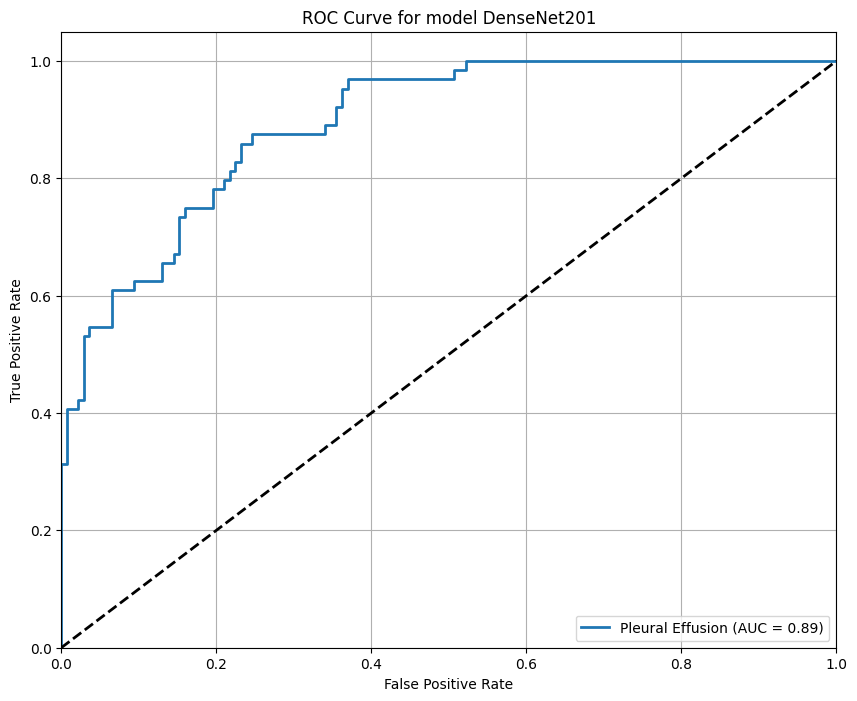

In [47]:
# model = load_model(filename="densenet169.pkl", device=device)
test_preds, test_labels = predict_model(model, test_loader, device)
# Plot ROC curve for the test dataset
plot_roc_curve(test_labels, test_preds, model_name='DenseNet201')

In [ ]:
# upload finetuned_models folder to drive as zip

import os
import zipfile

# Assuming 'finetuned_models' is in the current directory.
# Adjust the path if necessary.
folder_to_zip = 'finetuned_models'
zip_file_name = 'finetuned_models.zip'

# Create a zip archive of the 'finetuned_models' folder
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_to_zip):
        for file in files:
            zipf.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file),
                                       os.path.join(folder_to_zip, '..')))

# Upload the zip file to Google Drive
from google.colab import files
files.download(zip_file_name)


# Generating and Evaluating Explanations

In [48]:
%pip install lime
import lime.lime_tabular
import lime.lime_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d59f53c9feae531d4a20857d2e26332472491f98129f67ad2ad89b07d6a542f3
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [49]:
# read the ground truth data
import pandas as pd

path = "ground_truth_data/bbox320x320.xlsx" # change this to the path of the ground truth data
if is_colab():
    path = "/content/drive/MyDrive/UU/ground_truth_data/bbox320x320.xlsx" # "ground_truth_data/bbox320x320.xlsx" # change this to the path of the ground truth data
ground_truth_df = pd.read_excel(path)
ground_truth_df.head()

,Image,x_start,y_start,x_end,y_end,x_start.1,y_start .1,x_end .1,y_end.1
0,Test,48,160,144,288,NaN,NaN,NaN,NaN
1,Rad_1,176,128,288,256,NaN,NaN,NaN,NaN
2,Rad_2,32,128,144,256,NaN,NaN,NaN,NaN
3,Rad_3,32,144,144,288,176.0,144.0,288.0,272.0
4,Rad_5,32,160,144,240,NaN,NaN,NaN,NaN


In [50]:
images_paths = []
attributes_list = []

prefix_path = "./"
if is_colab():
    prefix_path = "/content/drive/MyDrive/UU/"

for row, column in ground_truth_df.iterrows():
    if column['Image '] != "Test ":

        path = f"{prefix_path}/ground_truth_images/{column['Image '].strip()}.png"
        images_paths.append(path)
        attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1',
       'y_start .1', 'x_end .1', 'y_end.1']])

labels = np.array([1, 1, 1, 1])

ground_truth_images_df = pd.DataFrame({"path": images_paths, "Pleural Effusion": labels})
ground_truth_images_df.head()

,path,Pleural Effusion
0,/content/drive/MyDrive/UU//ground_truth_images...,1
1,/content/drive/MyDrive/UU//ground_truth_images...,1
2,/content/drive/MyDrive/UU//ground_truth_images...,1
3,/content/drive/MyDrive/UU//ground_truth_images...,1


In [51]:
ground_truth_images_df

,path,Pleural Effusion
0,/content/drive/MyDrive/UU//ground_truth_images...,1
1,/content/drive/MyDrive/UU//ground_truth_images...,1
2,/content/drive/MyDrive/UU//ground_truth_images...,1
3,/content/drive/MyDrive/UU//ground_truth_images...,1


In [52]:
def evaluate_model(model, test_loader: DataLoader, criterion, device='cuda'):
    """
    Evaluate a trained PyTorch model on a test dataset.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function used during training.
    - device: Device to evaluate the model on ('cpu' or 'cuda').

    Returns:
    - test_loss: Average loss on the test dataset.
    - test_accuracy: Overall accuracy on the test dataset.
    - all_predictions: List of predicted values for all samples.
    - all_labels: List of ground-truth labels for all samples.
    """
    model.to(device) # Ensure the model is on the correct device
    model.eval()  # Set the model to evaluation mode

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the correct device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Convert outputs to binary predictions (multi-label classification)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            # Store predictions and labels
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.numel() # Total elements (samples × labels)

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Convert predictions and labels to tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy, all_predictions, all_labels

In [53]:
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, criterion, device=device)

Evaluating:   0%|          | 0/7 [00:00<?, ?batch/s]

Test Loss: 0.4435, Test Accuracy: 0.7921


In [54]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [55]:
%pip install grad-cam
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import ScoreCAM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s 

In [56]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import ScoreCAM

def apply_gradcam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided DenseNet121 model.

    Args:
        model: The trained DenseNet121 model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.
        target_category: (Optional) Target class index for which to compute Grad-CAM.

    Returns:
        Tuple of (resized original image, Grad-CAM heatmap, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert("RGB") # convert to grayscale # .convert('RGB')
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution

    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose the last conv layer in denseblock4.
    if target_layer is None:
        try:
            # Using the last convolution from denselayer16 in denseblock4       denseblock4{
            target_layer = [model.features.denseblock4.denselayer32.conv2] #  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                                                                                #} last layer  # otherwise this error https://github.com/jacobgil/pytorch-grad-cam/issues/393
        except AttributeError:
            # Fallback: use an alternative convolutional layer
            return "Not possible to extract the required convolutional layer due to missing attribute."

    # Create GradCAM object
    cam = GradCAM(model=model, target_layers=target_layer)

    targets = [ClassifierOutputTarget(0)]


    # print(targets)

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # print(grayscale_cam.min(), grayscale_cam.max())  # Before normalization
    # grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
    # print(grayscale_cam.min(), grayscale_cam.max())  # After normalization

    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape: #OTHERWISE  <<ValueError: operands could not be broadcast together with shapes (224,224,3) (320,357,3) THIS SH happens >>
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0]))
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True) # https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/utils/image.py

    return original_img_resized, overlay

### Visualisation of gradcam with ground truth bounding boxes

In [58]:
def visualize_gradcam_with_bbox(model, ground_truth_images_df, ground_truth_df, transform, display_only_effusion=True):
    """
    Visualize GradCAM heatmaps with bounding boxes for medical images.

    Parameters:
    -----------
    model : torch.nn.Module
        The trained model (DenseNet169) for which to compute GradCAM
    ground_truth_images_df : pandas.DataFrame
        DataFrame containing image paths and labels
    ground_truth_df : pandas.DataFrame
        DataFrame containing bounding box coordinates
    transform : torchvision.transforms
        Image transformations to apply
    display_only_effusion : bool, default=True
        If True, only process images with effusion (label == 1)
    """
    import cv2
    import matplotlib.pyplot as plt
    from PIL import Image
    import pandas as pd

    ground_truth_dataset, ground_truth_loader, ground_truth_images, ground_truth_labels = transform_dataset(ground_truth_images_df, zip_path, batch_size=batch_size, shuffle=False, augment=False, num_workers=num_of_workers)
    ground_truth_predicts, ground_truth_labels =  predict_model(model, ground_truth_loader, device)

    for i in range(ground_truth_images_df.shape[0]):
        image_path = ground_truth_images_df.iloc[i]['path']
        actual_label = ground_truth_images_df.iloc[i]["Pleural Effusion"]
        predicted_label = ground_truth_labels[i]

        # Load BBOX coordinates
        x_start, y_start, x_end, y_end, x_start_, y_start_, x_end_, y_end_ = ground_truth_df.iloc[i][
            ['x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1', 'y_start .1', 'x_end .1', 'y_end.1']
        ]

        print(f"actual label: {actual_label} and predicted label: {predicted_label}")

        # Skip non-effusion images if display_only_effusion is True
        if display_only_effusion and actual_label != 1:
            continue

        # Apply GradCAM
        original_img, overlay = apply_gradcam(
            model=model,
            image_path=image_path,
            transform=transform,
        )

        # Scale BBOX coordinates to 224x224
        original_width, original_height = Image.open(image_path).size
        scale_x = 224 / original_width
        scale_y = 224 / original_height

        x_start_rescaled = int(x_start * scale_x)
        y_start_rescaled = int(y_start * scale_y)
        x_end_rescaled = int(x_end * scale_x)
        y_end_rescaled = int(y_end * scale_y)

        # Optional handling for second bounding box if needed
        has_second_bbox = all(pd.notna(val) for val in [x_start_, y_start_, x_end_, y_end_])

        if has_second_bbox:
            x_start_rescaled_ = int(x_start_ * scale_x)
            y_start_rescaled_ = int(y_start_ * scale_y)
            x_end_rescaled_ = int(x_end_ * scale_x)
            y_end_rescaled_ = int(y_end_ * scale_y)

        # Draw primary BBOX on Original Image
        img_with_bbox = original_img.copy()
        cv2.rectangle(img_with_bbox,
                      (x_start_rescaled, y_start_rescaled),
                      (x_end_rescaled, y_end_rescaled),
                      color=(255, 255, 255),
                      thickness=1)

        # Draw primary BBOX on Grad-CAM Overlay
        overlay_with_bbox = overlay.copy()
        cv2.rectangle(overlay_with_bbox,
                      (x_start_rescaled, y_start_rescaled),
                      (x_end_rescaled, y_end_rescaled),
                      color=(255, 255, 255),
                      thickness=1)

        # Draw second BBOX if it exists
        if has_second_bbox:
            cv2.rectangle(img_with_bbox,
                          (x_start_rescaled_, y_start_rescaled_),
                          (x_end_rescaled_, y_end_rescaled_),
                          color=(0, 255, 0),  # Using green color for the second bbox
                          thickness=1)

            cv2.rectangle(overlay_with_bbox,
                          (x_start_rescaled_, y_start_rescaled_),
                          (x_end_rescaled_, y_end_rescaled_),
                          color=(0, 255, 0),  # Using green color for the second bbox
                          thickness=1)

        # Display Images
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img_with_bbox)
        plt.title("Resized Original Image with BBOX")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_with_bbox)
        plt.title("Grad-CAM Heatmap with BBOX")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

In [59]:
transform_eval = get_transform()

In [60]:
visualize_gradcam_with_bbox(
    model=model,
    ground_truth_images_df=ground_truth_images_df,
    ground_truth_df=ground_truth_df,
    transform=transform_eval
)

actual label: 1 and predicted label: [1.]


ValueError: operands could not be broadcast together with shapes (224,224,3) (224,224) 

In [ ]:
test_predicts, test_labels = predict_model(model, test_loader, device)
test_labels = test_labels.astype(int).squeeze()
test_labels.shape

In [ ]:
test_df_filtered = test_df[test_df['Pleural Effusion'] == 1]

# Get the indexes of the filtered DataFrame
filtered_indexes = test_df_filtered.index

# Filter test_predicts and test_labels using the filtered indexes
test_predicts_filtered = test_predicts[filtered_indexes]
test_labels_filtered = test_labels[filtered_indexes]

print(f"there are {test_df_filtered.shape[0]} images with Pleural Effusion")

In [ ]:
for i in range(15, 60, 5):
    image_path = test_df_filtered.iloc[i]['path']
    actual_label = test_df_filtered.iloc[i]["Pleural Effusion"]
    predicted_label = test_labels_filtered[i]

    print(f"actual label {actual_label} and predicted label {predicted_label}")
    original_img, overlay = apply_gradcam(
        model=model,
        image_path=image_path,
        transform=transform_eval,
    )
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Resized Original Image Pleural Effusion")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap Pleual Effusion")
    plt.axis("off")


    plt.show()

## Example-based explanation

### In this example, we do it based on ground_truth_images_df, first function is a class that extract features from specific layers
https://www.digitalocean.com/community/tutorials/pytorch-hooks-gradient-clipping-debugging#the-forward-hook-for-visualising-activations


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image

class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.model.eval()  # Set model to evaluation mode
        self.activations = dict()  # Store activations per sample and then .clear() it

    def hook_fn(self, module, input, output):
        self.activations['output'] = output  # Store feature map

    def get_embeddings(self, image_paths, transform):
        embeddings = []

        # Register hook
        hook_handle = self.model.features.register_forward_hook(self.hook_fn)

        with torch.no_grad():  # Prevents tracking gradients
            for idx, path in enumerate(image_paths):
                # Load and preprocess image
                image = Image.open(path).convert("RGB") # convert to grayscale # .convert('RGB')
                image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

                # Move the image tensor to the same device as the model
                image_tensor = image_tensor.to(next(self.model.parameters()).device)

                # Clear previous activations
                self.activations.clear()

                # Forward pass
                _ = self.model(image_tensor)

                # Retrieve hooked feature maps
                features = self.activations['output']

                # Apply ReLU activation
                features = F.relu(features, inplace=True)

                # Global average pooling
                pooled_features = F.adaptive_avg_pool2d(features, (1, 1))

                # Flatten into a 1D vector
                embedding = torch.flatten(pooled_features, 1)

                # Append to list after detaching from computation graph
                embeddings.append(embedding.detach().cpu())

                print(f"Processed image {idx+1}, embedding shape: {embedding.shape}")

        # Remove hook
        hook_handle.remove()

        return torch.cat(embeddings, dim=0)  # Combine all embeddings into one tensor

### Extracting ranked annotations

In [ ]:
import os
folder = prefix_path + "ranking_annotations"

ranking_image_paths = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("Rad")]

testing_image_path = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("test")]

ranking_image_paths


### Extraction and similarity of the most similar similar images according to Test image provided

In [ ]:
# Create feature extractor
extractor = FeatureExtractor(model)

# Extract embeddings
embeddings_torank = extractor.get_embeddings(image_paths=ranking_image_paths, transform=transform_eval)
embeddings_test = extractor.get_embeddings(image_paths=testing_image_path, transform=transform_eval)

In [ ]:
ranking_dict = dict()
for idx, embedding_torank in enumerate(embeddings_torank):
    similarity_score = F.cosine_similarity(embedding_torank, embeddings_test)
    print(f"Image path: {ranking_image_paths[idx]}, Similarity {float(similarity_score)}")
    ranking_dict[ranking_image_paths[idx]] = float(similarity_score)

sorted_ranking_dict = sorted(ranking_dict.items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted_ranking_dict

In [ ]:
def assign_ranks(image_scores):
    # Extract the scores from the list of tuples
    scores = [score for _, score in image_scores]

    # Normalize the scores to the range [0.5, 5.5]
    min_score = min(scores)
    max_score = max(scores)

    # Linear scaling from [min_score, max_score] to [0.5, 5.5]
    ranks = [
        0.5 + (score - min_score) * (5.5 - 0.5) / (max_score - min_score)
        for score in scores
    ]

    # Pair each image with its corresponding rank
    ranked_images = [(image_path, rank) for (image_path, _), rank in zip(image_scores, ranks)]

    return ranked_images

ranked_images = assign_ranks(sorted_ranking_dict)

# Output the ranked images
for image, rank in ranked_images:
    print(f"Image: {image}, Rank: {rank}")

In [ ]:
import re
from sklearn.metrics import ndcg_score
import numpy as np
def dcg_calculation(sorted_ranking_dict):
    # Relevance scores in Ideal order
    true_relevance = np.asarray([[1,2,3,4,5,6,7,8,9,10]])

    # Relevance scores in output order by retreiving the order from cosine similarity dictionary
    output_order = [int(re.search(r'Rad_(\d+)', entry[0]).group(1)) for entry in sorted_ranking_dict]
    relevance_score = np.asarray([output_order])

    print("nDCG score : ", ndcg_score(
        true_relevance, relevance_score))
dcg_calculation(sorted_ranking_dict)

### GradCAM on the test image

In [ ]:
test_image_path = prefix_path + 'ranking_annotations/test_image.png'
original_img, overlay = apply_gradcam(
        model=model,
        image_path=test_image_path,
        transform=transform_eval,
    )


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Resized Original Image Pleural Effusion")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap Pleual Effusion")
plt.axis("off")


plt.show()

### Gradcam on sorted by similarity samples

In [ ]:
for i in range(len(sorted_ranking_dict)):

    image_path = sorted_ranking_dict[i][0]

    original_img, overlay = apply_gradcam(
            model=model,
            image_path=image_path,
            transform=transform_eval)


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Resized Original Image Pleural Effusion")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap Pleual Effusion")
    plt.axis("off")


    plt.show()

### Metrics